# CSX46 - Class 19 - MCODE

In this notebook, we will analyze a simple graph (`test.dot`) and then the Krogran network using the MCODE community detection algorithm.

In [1]:
import pygraphviz
import igraph
import numpy
import pandas
import sys
from collections import defaultdict

In [2]:
test_graph = pygraphviz.AGraph("shared/test.dot")
nodes = test_graph.nodes()
edges = test_graph.edges()
test_igraph = igraph.Graph.TupleList(edges)
test_igraph.summary()

'IGRAPH UN-- 13 26 -- \n+ attr: name (v)'

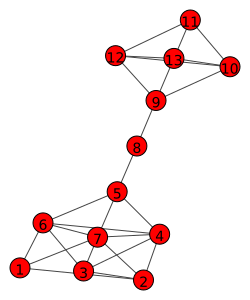

In [3]:
igraph.drawing.plot(test_igraph, bbox=[0, 0, 250, 300], 
                    vertex_label=test_igraph.vs()['name'])

Function `mcode` takes a graph adjacency list `adj_list` and a float parameter `vwp` (vertex weight probability), and returns a list of cluster assignments (of length equal to the number of clusters).  Original code from True Price at UNC Chapel Hill [link to original code](https://github.com/trueprice/python-graph-clustering/blob/master/src/mcode.py).

In [4]:
def mcode(adj_list, vwp):
  
  # Stage 1: Vertex Weighting
  N = len(adj_list)
  edges = [[]]*N
  weights = dict((v, 1.) for v in range(0,N))

  edges=defaultdict(set)
  for i in range(0,N):
    edges[i] = set(adj_list[i])
    
  res_clusters = []

  for i,v in enumerate(edges):
    neighborhood = set((v,)) | edges[v]
    # if node has only one neighbor, we know everything we need to know
    if len(neighborhood) <= 2: continue

    # see if larger k-cores exist
    k = 1 # highest valid k-core
    while neighborhood:
      k_core = neighborhood.copy()
      invalid_nodes = True
      while invalid_nodes and neighborhood:
        invalid_nodes = set(
          n for n in neighborhood if len(edges[n] & neighborhood) <= k)
        neighborhood -= invalid_nodes
      k += 1 # on exit, k will be one greater than we want
    # vertex weight = k-core number * density of k-core
    weights[v] = (k-1) * (sum(len(edges[n] & k_core) for n in k_core) / 
      (2. * len(k_core)**2))

  # Stage 2: Molecular Complex Prediction
  unvisited = set(edges)
  num_clusters = 0
  for seed in sorted(weights, key=weights.get, reverse=True):
    if seed not in unvisited: continue

    cluster, frontier = set((seed,)), set((seed,))
    w = weights[seed] * vwp
    while frontier:
      cluster.update(frontier)
      unvisited -= frontier
      frontier_plus_neighbors = set.union(*(edges[n] for n in frontier))
      frontier = set(        
        n for n in frontier_plus_neighbors & unvisited if weights[n] > w)

    # haircut: only keep 2-core complexes
    invalid_nodes = True
    while invalid_nodes and cluster:
      invalid_nodes = set(n for n in cluster if len(edges[n] & cluster) < 2)
      cluster -= invalid_nodes

    if cluster:
      res_clusters = res_clusters + [list(cluster)]
      num_clusters += 1

  return(res_clusters)





Run mcode on the adjacency list for your toy graph, with vwp=0.8. How many clusters did it find? Do the cluster memberships make sense?

In [5]:
mcode(test_igraph.get_adjlist(), 0.8)

[[1, 2, 3, 4, 5, 6], [8, 9, 10, 11, 12]]

Load the Krogan et al. network edge-list data as a Pandas data frame

In [6]:
edge_list = pandas.read_csv("shared/krogan.sif",
                                 sep="\t", 
                                 names=["protein1","protein2"])

Make an igraph graph and print its summary

In [7]:
krogan_graph = igraph.Graph.TupleList(edge_list.values.tolist(), directed=False)
krogan_graph.summary()

'IGRAPH UN-- 2674 7079 -- \n+ attr: name (v)'

Run mcode on your graph with vwp=0.1

In [8]:
res = mcode(krogan_graph.get_adjlist(), 0.1)

Get the cluster sizes

In [9]:
[len(x) for x in res]

[635, 541, 4, 3, 5, 3, 4, 3, 3, 3, 3, 3]